In [1]:
import warnings
from datetime import timedelta, date

import pandas as pd
import polars as pl

from core.time_utils import Bounds

warnings.simplefilter("ignore")

<h4>In this notebook we want to make that we don't show future to the model through our regressors</h4>

<h4>Fetch data from Hive structure</h4>

In [2]:
bounds: Bounds = Bounds.for_days(date(2024, 1, 1), date(2024, 1, 2))
# Expand bounds such that start and end of the daily interval will not have missing values
expanded_bounds: Bounds = bounds.expand_bounds(lb_timedelta=timedelta(minutes=5), rb_timedelta=timedelta(minutes=5))

df_ticks = (
    pl.scan_parquet(r"D:\data\transformed\trades")
    .filter(
        (pl.col("date").is_between(expanded_bounds.day0, expanded_bounds.day1)) &
        (pl.col("symbol") == "BTC-USDT") &
        (pl.col("trade_time").is_between(expanded_bounds.start_inclusive, expanded_bounds.end_exclusive))
    )
    .collect()
)

In [3]:
date_index: pd.DatetimeIndex = pd.date_range(
    bounds.start_inclusive, bounds.end_exclusive, freq=timedelta(milliseconds=500), inclusive="left"
)
df_index: pl.DataFrame = pl.DataFrame({"sampled_time": date_index})

<h4>Make sure data is sorted by trade_time</h4>

In [4]:
df_ticks = df_ticks.sort(by="trade_time", descending=False)
assert df_ticks["trade_time"].is_sorted()

In [5]:
df_ticks = df_ticks.with_columns(
    quote_abs=pl.col("price") * pl.col("quantity"),
    side=1 - 2 * pl.col("is_buyer_maker")  # -1 if SELL, 1 if BUY
)
df_ticks = df_ticks.with_columns(
    quote_sign=pl.col("quote_abs") * pl.col("side"),
    quantity_sign=pl.col("quantity") * pl.col("side")
)

<h4>Aggregate ticks into trades on trade_time</h4>

In [6]:
df_ticks = df_ticks.sort(by="trade_time", descending=False)

df_trades: pl.DataFrame = (
    df_ticks
    .group_by("trade_time", maintain_order=True)
    .agg(
        price_first=pl.col("price").first(),  # if someone placed a trade with price impact, then price_first
        price_last=pl.col("price").last(),  # and price_last will differ
        # Amount spent in quote asset for the trade
        quote_abs=pl.col("quote_abs").sum(),
        quote_sign=pl.col("quote_sign").sum(),
        quantity_sign=pl.col("quantity_sign").sum(),
        # Amount of base asset transacted
        quantity_abs=pl.col("quantity").sum(),
        num_ticks=pl.col("price").count(),  # number of ticks for each trade
    )
)
# Create boolean indicating if the trade was long or short
df_trades = df_trades.with_columns(
    (pl.col("quote_sign") >= 0).alias("is_long")
)

df_trades

trade_time,price_first,price_last,quote_abs,quote_sign,quantity_sign,quantity_abs,num_ticks,is_long
datetime[ns],f64,f64,f64,f64,f64,f64,u32,bool
2024-01-01 00:00:00,42283.58,42283.58,29.17567,-29.17567,-0.00069,0.00069,1,false
2024-01-01 00:00:00.001,42283.59,42283.59,60.88837,60.88837,0.00144,0.00144,1,true
2024-01-01 00:00:00.003,42283.58,42283.59,135.730314,49.47181,0.00117,0.00321,2,true
2024-01-01 00:00:00.004,42283.59,42283.59,68.922252,68.922252,0.00163,0.00163,1,true
2024-01-01 00:00:00.005,42283.59,42283.59,178.43675,178.43675,0.00422,0.00422,2,true
…,…,…,…,…,…,…,…,…
2024-01-02 00:04:59.995,44264.26,44264.32,103.578437,103.578437,0.00234,0.00234,3,true
2024-01-02 00:04:59.996,44261.11,44264.33,176.166452,23.023011,0.00052,0.00398,3,true
2024-01-02 00:04:59.997,44264.33,44264.37,69.052372,69.052372,0.00156,0.00156,4,true


In [7]:
# compute slippage
df_trades = df_trades.with_columns(
    quote_slippage_abs=(pl.col("quote_abs") - pl.col("price_first") * pl.col("quantity_abs")).abs()
)
df_trades = df_trades.with_columns(
    quote_slippage_sign=pl.col("quote_slippage_abs") * pl.col("quantity_sign").sign()
)

In [15]:
df_trades = df_trades.with_columns(
    price_last_prev=pl.col("price_last").shift(1),
    trade_time_prev=pl.col("trade_time").shift(1)
)

df_trades.head()

trade_time,price_first,price_last,quote_abs,quote_sign,quantity_sign,quantity_abs,num_ticks,is_long,quote_slippage_abs,quote_slippage_sign,price_last_prev,trade_time_prev
datetime[ns],f64,f64,f64,f64,f64,f64,u32,bool,f64,f64,f64,datetime[ns]
2024-01-01 00:00:00,42283.58,42283.58,29.17567,-29.17567,-0.00069,0.00069,1,false,0.0,-0.0,null,null
2024-01-01 00:00:00.001,42283.59,42283.59,60.88837,60.88837,0.00144,0.00144,1,true,0.0,0.0,42283.58,2024-01-01 00:00:00
2024-01-01 00:00:00.003,42283.58,42283.59,135.730314,49.47181,0.00117,0.00321,2,true,0.000022,0.000022,42283.59,2024-01-01 00:00:00.001
2024-01-01 00:00:00.004,42283.59,42283.59,68.922252,68.922252,0.00163,0.00163,1,true,0.0,0.0,42283.59,2024-01-01 00:00:00.003
2024-01-01 00:00:00.005,42283.59,42283.59,178.43675,178.43675,0.00422,0.00422,2,true,0.0,0.0,42283.59,2024-01-01 00:00:00.004


In [22]:
(
    df_trades
    .group_by_dynamic(
        index_column="trade_time",
        every=timedelta(milliseconds=500),
        period=timedelta(milliseconds=500),
        closed="right",
        label="right"
    )
    .agg(
        pl.col("price_last").std()
    )
)

trade_time,price_last
datetime[ns],f64
2024-01-01 00:00:00,null
2024-01-01 00:00:00.500,0.005045
2024-01-01 00:00:01,0.007071
2024-01-01 00:00:01.500,0.003807
2024-01-01 00:00:02,0.004577
…,…
2024-01-02 00:04:58,0.005164
2024-01-02 00:04:58.500,0.005345
2024-01-02 00:04:59,0.0


<h4>Add lags of time and price will help when resampling</h4>

In [65]:
sampled_features: pl.DataFrame = (
    df_trades
    .group_by_dynamic(
        index_column="trade_time",
        every=timedelta(milliseconds=500),
        period=timedelta(milliseconds=1000),
        closed="right",
        label="right",
        include_boundaries=True
    )
    .agg(
        asset_return=(pl.col("price_last").last() / pl.col("price_last_prev").first() - 1) * 1e4,
        asset_hold_time=(pl.col("trade_time").last() - pl.col("trade_time_prev").first()).dt.total_nanoseconds() / 1e9,
        flow_imbalance=pl.col("quote_sign").sum() / pl.col("quote_abs").sum(),
        slippage_imbalance=pl.col("quote_slippage_sign").sum() / pl.col("quote_slippage_abs").sum(),
        powerlaw_alpha=1 + pl.len() / (pl.col("quote_abs") / pl.col("quote_abs").min()).log().sum(),
        share_of_longs=pl.col("is_long").sum() / pl.len(),
        sigma=pl.col("price_last").std(),
        close_price=pl.col("price_last").last()
    )
    .filter(
        pl.col("trade_time").is_between(bounds.start_inclusive, bounds.end_exclusive)
    )
)

sampled_features = (
    df_index
    .join(sampled_features, left_on="sampled_time", right_on="trade_time", how="left")
    .with_columns(
        # Post process some features
        # 1. fillnans in asset_return with 0
        asset_return=pl.col("asset_return").fill_null(0),
        asset_return_adj=pl.col("asset_return") * (
                timedelta(milliseconds=500).total_seconds() / pl.col("asset_hold_time")),
        # 2. forward fill close_price
        close_price=pl.col("close_price").forward_fill()
    )
)

In [66]:
sampled_features.to_pandas().isna().sum()

sampled_time               0
_lower_boundary         8881
_upper_boundary         8881
asset_return               0
asset_hold_time         8882
flow_imbalance          8881
slippage_imbalance    122557
powerlaw_alpha          8881
share_of_longs          8881
sigma                  28506
close_price                1
asset_return_adj        8882
dtype: int64

<Axes: >

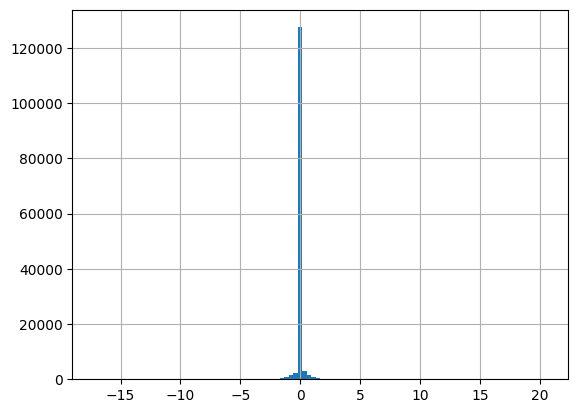

In [31]:
sampled_features.to_pandas()["asset_return_adj"].hist(bins=100)

In [32]:
sampled_features.to_pandas()["asset_return_adj"].describe()

count    139447.000000
mean          0.002617
std           0.344133
min         -17.136150
25%          -0.001025
50%           0.000000
75%           0.001090
max          20.463659
Name: asset_return_adj, dtype: float64

In [ ]:
cols = [
    "asset_return",
    "asset_hold_time",
    "flow_imbalance",
    "slippage_imbalance",
    "powerlaw_alpha",
    "share_of_longs"
]

<h4>Validate that everything is computed correctly</h4>

In [ ]:
from core.paths import FEATURE_DIR
from core.time_utils import Bounds
from datetime import date
from feature_writer.utils import to_wide_format
from core.currency_pair import CurrencyPair

import polars as pl

hive: pl.LazyFrame = pl.scan_parquet(FEATURE_DIR)
bounds: Bounds = Bounds.for_days(
    date(2024, 1, 1), date(2024, 1, 4)
)

data = hive.filter(
    (pl.col("currency_pair") == CurrencyPair.from_string("BTC-USDT").name) &
    (pl.col("date").is_between(bounds.day0, bounds.day1))
).collect()

In [ ]:
to_wide_format(data)